# 11 Image segmentation

## Computer vision tasks

In [2]:
import os
import sys
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.magic import register_cell_magic

import keras

os.environ["KERAS_BACKEND"] = "jax"

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

- *Image classification*: assign one or more labels to an images;
- *Image segmentation*: partition image into different areas (locating categories of bojects), operates on **pixels**;
- *Object detection*: draw rectangles around object.

<!-- ![Chollet three tasks](images/chollet/figure11.1.png) -->
![Chollet three tasks](https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05.more/images/chollet/figure11.1.png)

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#computer-vision-tasks), Chapter 11, figure 11.1</small>

### Types of image segmentation

- *Semantic segmentation*:  each pixel is independently classified into a semantic category, like “cat.” (Two cats belong to the same category).
- *Instance segmentation*: parses out individual object instances. (Two cats are labelled `cat 1` and `cat 2`.)
- *Panoptic segmentation*? which combines the two previous approaches, giving both a semantic label and and an instance label.

<!-- ![Chollet, Semantic segmentation vs. instance segmentation](images/chollet/figure11.2.png) -->
![Chollet, Semantic segmentation vs. instance segmentation](https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05.more/images/chollet/figure11.2.png)

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#types-of-image-segmentation), Chapter 11, figure 11.2</small>

## Training a segmentation model from scratch

[Oxford pets reference page](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [3]:
REPO_DIR = pathlib.Path("oxford-pets")
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/ml4py/dataset-iiit-pet oxford-pets/dataset-iiit-pet

Cloning into 'oxford-pets/dataset-iiit-pet'...
remote: Enumerating objects: 18465, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18465 (delta 1), reused 3 (delta 1), pack-reused 18460 (from 1)
Receiving objects: 100% (18465/18465), 772.55 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.
Updating files: 100% (18477/18477), done.


In [4]:
!ls oxford-pets

dataset-iiit-pet


In [5]:
BATCH_SIZE = 64
IMG_SIZE = (200, 200)

BASE_DIR = REPO_DIR / "dataset-iiit-pet"
INPUT_DIR = BASE_DIR / "images/"
TARGET_DIR = BASE_DIR / "annotations/trimaps/"

INPUT_IMG_PATHS = sorted(INPUT_DIR.glob("*.jpg"))

TARGET_PATHS = sorted(TARGET_DIR.glob("[!.]*.png"))

image shape: (500, 448)


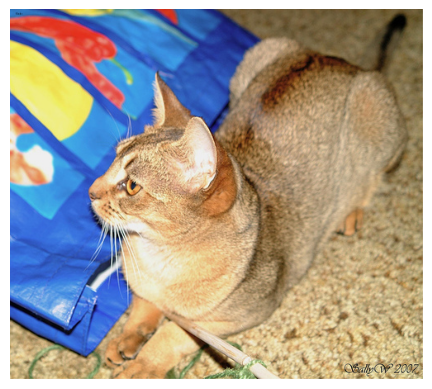

In [6]:
plt.axis("off")
img = keras.utils.load_img(INPUT_IMG_PATHS[9])
plt.imshow(keras.utils.load_img(INPUT_IMG_PATHS[9]))
print(f"image shape: {img.size}")

array shape: (448, 500, 1)
values: [  0 127 254]


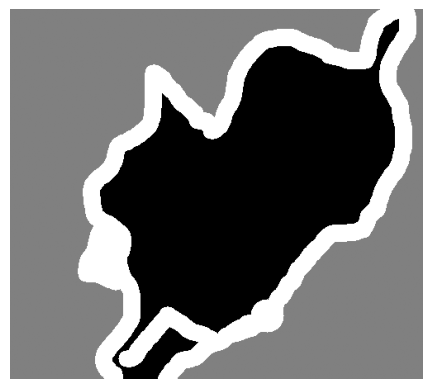

In [7]:
def display_target(target_array):
    print(f"array shape: {target_array.shape}")
    normalized_array = (target_array.astype("uint8") - 1) * 127
    values = np.unique(normalized_array.reshape(-1,))

    # background is 127 (grey), boundary is 256 (white), object 0 (black)
    print(f"values: {values}")
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0], cmap="gray")

# "grayscale" mode yields a (W, H, 1) image – without it it would be (W, H, 3)
img = keras.utils.img_to_array(keras.utils.load_img(TARGET_PATHS[9], color_mode="grayscale"))
display_target(img)

In [10]:
# Total number of samples in the data
num_imgs = len(INPUT_IMG_PATHS)

# Shuffles the file paths (they were originally sorted by breed). We
# use the same seed (1337) in both statements to ensure that the input
# paths and target paths stay in the same order.
random.Random(1337).shuffle(INPUT_IMG_PATHS)
random.Random(1337).shuffle(TARGET_PATHS)

def path_to_input_image(path):
    return keras.utils.img_to_array(keras.utils.load_img(path, target_size=IMG_SIZE))

def path_to_target(path):
    img = keras.utils.img_to_array(
        keras.utils.load_img(path, target_size=IMG_SIZE, color_mode="grayscale")
    )
    # Subtracts 1 so that our labels become 0, 1, and 2
    img = img.astype("uint8") - 1
    return img

# Loads all images in the input_imgs float32 array and their masks in
# the targets uint8 array (same order). The inputs have three channels
# (RGB values), and the targets have a single channel (which contains
# integer labels).
input_imgs = np.zeros((num_imgs,) + IMG_SIZE + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + IMG_SIZE + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(INPUT_IMG_PATHS[i])
    targets[i] = path_to_target(TARGET_PATHS[i])


In [11]:
# Reserves 1,000 samples for validation
num_val_samples = 1000
# Splits the data into a training and a validation set
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## Model

In [12]:
def get_model(IMG_SIZE, num_classes, tf_dataset=True):
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = keras.layers.Rescaling(1./255)(inputs)

    # shrink input (like an encoder)
    x = keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # unshrink input (like a decoder)
    x = keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(IMG_SIZE=IMG_SIZE, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

### Transposed Convolutions

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05.more/images/deconv/deconv.1.png)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05.more/images/deconv/deconv.2.png)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

## Compilation & Training

In [13]:
# ⚠️NOTE⚠️: The following IoU metric is *very* slow on the PyTorch backend!
# If you are running with PyTorch, we recommend re-running the notebook with Jax
# or TensorFlow, or skipping to the next section of this chapter.

foreground_iou = keras.metrics.IoU(
    # Specifies the total number of classes
    num_classes=3,
    # Specifies the class to compute IoU for (0 = foreground)
    target_class_ids=(0,),
    name="foreground_iou",
    # Our targets are sparse (integer class IDs).
    sparse_y_true=True,
    # But our model's predictions are a dense softmax!
    sparse_y_pred=False,
)

In [14]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=[foreground_iou],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(BASE_DIR, "oxford_segmentation.keras"),
        save_best_only=True
    )
]

# to revert back to Chollet's version, follow the comments
history = model.fit(
    train_input_imgs,
    train_targets,
    epochs=50,
    batch_size=BATCH_SIZE,
    #  Chollet: validation_data=(val_input_imgs, val_targets)
    validation_data=(val_input_imgs, val_targets),
    callbacks=callbacks,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 316ms/step - foreground_iou: 0.0030 - loss: 0.9377 - val_foreground_iou: 0.0000e+00 - val_loss: 0.8759
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - foreground_iou: 0.1987 - loss: 0.8664 - val_foreground_iou: 0.2788 - val_loss: 0.8278
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - foreground_iou: 0.4020 - loss: 0.8271 - val_foreground_iou: 0.3729 - val_loss: 0.8110
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - foreground_iou: 0.4261 - loss: 0.8114 - val_foreground_iou: 0.4650 - val_loss: 0.7787
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - foreground_iou: 0.4431 - loss: 0.7927 - val_foreground_iou: 0.4730 - val_loss: 0.7652
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - foreground_iou: 0.4641 - loss: 0.7627 - val_foreground_iou: 0.4941 - val_loss: 0.7241
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - foreground_iou: 0.4630 - loss: 0.7685 - val_foreground_iou: 0.4919 - val_loss: 0.7392
Epoch 8

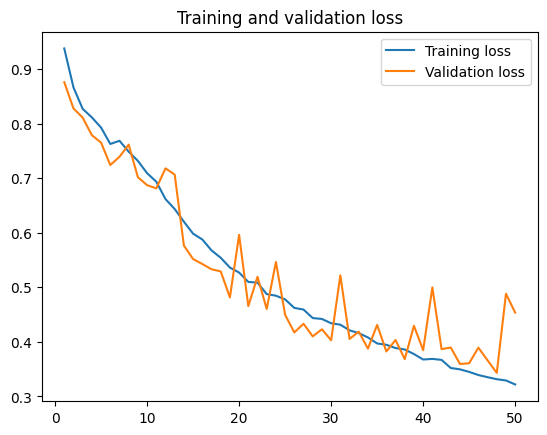

In [15]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [16]:
def display_mask(model, i):

    # get image
    test_image = val_input_imgs[i]

    # get mask
    pred = model.predict(np.expand_dims(test_image, 0), verbose=0)[0]
    mask = np.argmax(pred, axis=-1)
    mask *= 127

    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis("off")
    ax1.imshow(keras.utils.array_to_img(test_image))
    ax2.axis("off")
    ax2.imshow(mask, cmap="gray")
    plt.show()

In [17]:
reloaded_model = keras.models.load_model(os.path.join(BASE_DIR, "oxford_segmentation.keras"))

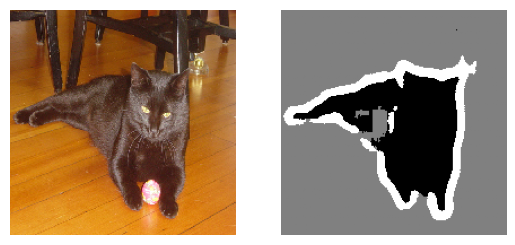

In [21]:
i = np.random.randint(0, len(val_input_imgs))
display_mask(reloaded_model, i)

## Using a pretrained segmentation model

Check out the steps [in the book](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#using-a-pretrained-segmentation-model)!

### See also

[Keras tutorial on Segment Anything](https://keras.io/keras_hub/guides/segment_anything_in_keras_hub/)  
["Automatically generating object masks with SAM" notebook (Keras)](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Automatic_Mask_Generator_Demo.ipynb)  
[Facebook Research's "Segment Anything"](https://github.com/facebookresearch/segment-anything) and ["Segment Anything 2"](https://github.com/facebookresearch/sam2) GitHub repositories